<a href="https://colab.research.google.com/github/restrepo/ComputationalMethods/blob/master/material/interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpolation Methods
<a href="https://colab.research.google.com/github/restrepo/ComputationalMethods/blob/master/material/interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Due to the discrete (and sometimes sparse) nature of experiments and observations, data taking procedures will always produce discrete data as well. Even, as we have seen before, information only can be discretely presented into a computer due to the binary representation. However, when we are dealing with physical models, continuous and smooth properties are of course preferred. Interpolation techniques allow then to recover a continuous field (intermediate values) from sparse datasets. Throughout this section we shall cover some of these interpolation methods.

---

<!-- __Homework__: https://classroom.github.com/a/SB94rDVJ -->
## Bibliography: 
[1a] Gonzalo Galiano Casas, Esperanza García Gonzalo [Numerical Computation](https://www.unioviedo.es/compnum/expositive/handbook/metnum.pdf) - [GD](https://drive.google.com/file/d/1gwHYLx5aBf3oXRhmGeG-n1toTtAUhvfX/view?usp=sharing) - [Web page with notebooks](https://www.unioviedo.es/compnum/index.php/english-menu)<br/>
[1g] Mo Mu, [MATH 3311: Introduction to Numerical Methods](https://www.math.ust.hk/~mamu/courses/230/course.htm) [GD](https://drive.google.com/drive/folders/1vv38SS7Zpw8mOHG7Kq_3lZr6o9H4xOYP?usp=sharing) - [Demostration Error in Lagrange Polynomials](https://www.math.ust.hk/~mamu/courses/231/Slides/CH03_1B.pdf)<br/>
[1h] Zhiliang Xu, [ACMS 40390: Fall 2016 - Numerical Analysis](https://www3.nd.edu/~zxu2/ACMS40390-F16.html) [GD](https://drive.google.com/drive/folders/1Z9Fws1v34PuPdGAp_mBCWmTvZM_Qd6Xk?usp=sharing)</br>


https://github.com/restrepo/Calculus/blob/master/Differential_Calculus.ipynb


- - -
- [NumPy polynomials](#NumPy-Polynomials)
- [Linear Interpolation](#Linear-Interpolation)
    - [Steps](#Steps-LI)
    - [Example 1](#Example-1)
- [Lagrange Polynomial](#Lagrange-Polynomial)
    - [Derivation](#Derivation)
    - [Steps](#Steps-LP)
    - [Activity](#Activity-LP)
- [Divided Differences](#Divided-Differences)
    - [Example 2](#Example-2)
- [Hermite Interpolation](#Hermite-Interpolation)
    - [Derivation in terms of divided differences](#Derivation-in-terms-of-divided-differences)
    - [Example 3](#Example-3)
- - -

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython.display import display, Markdown, Latex, Image 
import pandas as pd

In [3]:
from scipy import interpolate

In [4]:
import numpy as np
# JSAnimation import available at https://github.com/jakevdp/JSAnimation
#from JSAnimation import IPython_display
from matplotlib import animation
from IPython.core.display import Image 

Pretty print inside colaboratory

In [5]:
import IPython

def setup_typeset():
  """MathJax initialization for the current cell.
  
  This installs and configures MathJax for the current output.
  """
  IPython.display.display(IPython.display.HTML('''
      <script src="https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=TeX-AMS_HTML-full,Safe&delayStartupUntil=configured"></script>
      <script>
        (() => {
          const mathjax = window.MathJax;
          mathjax.Hub.Config({
          'tex2jax': {
            'inlineMath': [['$', '$'], ['\\(', '\\)']],
            'displayMath': [['$$', '$$'], ['\\[', '\\]']],
            'processEscapes': true,
            'processEnvironments': true,
            'skipTags': ['script', 'noscript', 'style', 'textarea', 'code'],
            'displayAlign': 'center',
          },
          'HTML-CSS': {
            'styles': {'.MathJax_Display': {'margin': 0}},
            'linebreaks': {'automatic': true},
            // Disable to prevent OTF font loading, which aren't part of our
            // distribution.
            'imageFont': null,
          },
          'messageStyle': 'none'
        });
        mathjax.Hub.Configured();
      })();
      </script>
      '''))
    
def Polynomial_to_LaTeX(p):
    """ Small function to print nicely the polynomial p as we write it in maths, in LaTeX code."""
    coefs = p.coef[::-1]  # List of coefficient, sorted by increasing degrees
    res = ""  # The resulting string
    for i, a in enumerate(coefs):
        if int(a) == a:  # Remove the trailing .0
            a = int(a)
        if i == 0:  # First coefficient, no need for X
            if a > 0:
                res += "{a} + ".format(a=a)
            elif a < 0:  # Negative a is printed like (a)
                res += "({a}) + ".format(a=a)
            # a = 0 is not displayed 
        elif i == 1:  # Second coefficient, only X and not X**i
            if a == 1:  # a = 1 does not need to be displayed
                res += "x + "
            elif a > 0:
                res += "{a} \;x + ".format(a=a)
            elif a < 0:
                res += "({a}) \;x + ".format(a=a)
        else:
            if a == 1:
                # A special care needs to be addressed to put the exponent in {..} in LaTeX
                res += "x^{i} + ".format(i="{%d}" % i)
            elif a > 0:
                res += "{a} \;x^{i} + ".format(a=a, i="{%d}" % i)
            elif a < 0:
                res += "({a}) \;x^{i} + ".format(a=a, i="{%d}" % i)
    return "$" + res[:-3] + "$" if res else ""    

- - -

# NumPy Polynomials

In Numpy there is an implementation of Polynomials. The object is initialized giving the polynomial coefficients: 

More information about this
* [LaTeX print](https://perso.crans.org/besson/publis/notebooks/Demonstration%20of%20numpy.polynomial.Polynomial%20and%20nice%20display%20with%20LaTeX%20and%20MathJax%20(python3).html): 

In [26]:
p = np.poly1d([1, 2, -3])
print(p)

   2
1 x + 2 x - 3


In [31]:
print('\thola\nmundo\\')

	hola
mundo\


In [27]:
Polynomial_to_LaTeX(p)

'$(-3) + 2 \\;x + x^{2}$'

In a text cell: $(-3) + 2 \;x + x^{2}$

In [18]:
Latex(Polynomial_to_LaTeX(p))

<IPython.core.display.Latex object>

The numpy polynomial is automatically a function of its variable $x$

In [47]:
p(1.3)

1.29

By default, the assigned the attribute `variable` is `x`:

In [32]:
p.variable

'x'

which can be assigned at initialization 

In [33]:
q = np.poly1d([1, 2, -3],variable='t')
print(q)

   2
1 t + 2 t - 3


Change of variable

In [46]:
p = np.poly1d([1, 2, -3])
print(p)

   2
1 x + 2 x - 3


In [44]:
pp=np.poly1d(p.coef,variable='t')
print(pp)

   2
1 t + 2 t - 3


Polynomial can be added but not multiplied, simplified or expanded

In [15]:
p1=np.poly1d([1,1])
print('p1(x)={}'.format(p1))
print('*'*20)
p2=np.poly1d([-1,1])
print('p2(x)={}'.format(p2))
print('*'*20)
print('p1(x)+p2(x)={}'.format(p1+p2))

p1(x)= 
1 x + 1
********************
p2(x)= 
-1 x + 1
********************
p1(x)+p2(x)= 
2


The object have in particular methods for <br/>
__Integration__:

In [11]:
p1+p2

poly1d([2])

In [36]:
print(p)

   2
1 x + 2 x - 3


In [39]:
print(p)

   4             2
1 x - 6.221e+04 x + 9.698e+07


In [34]:
p = np.poly1d([1, 2, -3])
print( p.integ() )

        3     2
0.3333 x + 1 x - 3 x


__Derivatives__

In [ ]:
print( p.deriv() )

 
2 x + 2


__roots__:

In [37]:
setup_typeset() #active colab pretty print
print(p.roots)
Latex( '$p({})$={}'.format(round(p.roots[0],1),
                                      p((p.roots[0] )  ) ) )

[-3.  1.]


<IPython.core.display.Latex object>

 It is possible to define polynomial by given the list of roots and 

In [38]:
p=np.poly1d([-246.2,-40,40,246.2],r=True)
print(p)

   4             2
1 x - 6.221e+04 x + 9.698e+07


For further details check the official help:

In [ ]:
np.poly1d?

__Activity__:  Movement with uniform acceleration
1. Define a polynomial for the movement with uniform acceleration:
\begin{align}
x(t)=x_0+v_0 (t-t_0)+\tfrac{1}{2} a (t-t_0)^2 \,,
\end{align}
2. Use the previous formula expressed as polynomial of degree 2, to solve the following problem with `np.poly1d`: 
    * A car departs from rest with a constant acceleration of $6~\text{m}\cdot\text{s}^{-2}$ and travels through a flat and straight road. 10 seconds later a second pass for the same starting point and in the same direction with an initial speed of $10~\text{m}\cdot\text{s}^{-1}$ and a constant acelleration of $10~\text{m}\cdot\text{s}^{-2}$. Find the time and distance at which the two cars meet.
    
_Hint_. 
\begin{align}
x(t)=x_0-v_0t_0+\frac{1}{2}at_0^2 +(v_0-at_0)t+\tfrac{1}{2} a t^2 
\end{align}


<!-- ### <font color=red>Solution</font>
setup_typeset() #active colab pretty print
def x(x0,t0,v0,a):
    return np.poly1d( [0.5*a,v0-a*t0,x0-v0*t0+0.5*a*t0**2],
                     variable='t'  )
x1=x(0,0,0,6)
x2=x(0,10,10,10)
display(Latex('$x_1(t)=$'))
print(x1) 
display(Latex('$x_2(t)=$'))
print(x2)
t=np.linspace(0,45,100)
plt.plot(t,x2(t)-x1(t))
plt.grid()
#plt.plot(t,(x2-x1)(t))
#plt.grid()
#Physica solution is the one after 10s
Latex(r'meeting time $t_{\rm end}=$ %g s; meeting point $x_{\rm end}=$ %g m' 
          %(  (x2-x1).r[0]  ,  x2(  (x2-x1).r[0]  )   )) 
#plt.plot(t,x2(t),'ro')
#plt.plot(t,x2(t),'k-')
#plt.xlim(10,15)
#plt.ylim(0,200)          
          -->

# Linear Interpolation

When we have a set of discrete points of the form $(x_i, y_i)$ for $1\leq i \leq N$, the most natural way to obtain (approximate) any intermediate value is assuming points connected by lines. Let's assume a set of points $(x_i, y_i)$ such that $y_i = f(x_i)$ for an unknown function $f(x)$, if we want to approximate the value $f(x)$ for $x_i\leq x \leq x_{i+1}$, we construct an equation of a line passing through $(x_i,y_i)$ and $(x_{i+1},y_{i+1})$.

The linear equation is

$$y=mx+b$$

where

$$m=\frac{y_{i+1}-y_i}{x_{i+1}-x_i} $$

and $b$ is obtained by evaluating with either $(x_i,y_i)$ or $(x_{i+1},y_{i+1})$

$$y=\frac{y_{i+1}-y_i}{x_{i+1}-x_i}x+b$$

$$b=y_i-\frac{y_{i+1}-y_i}{x_{i+1}-x_i}x_i$$


\begin{align}
%$$  
f(x)\approx y = &\frac{y_{i+1}-y_i}{x_{i+1}-x_i}(x-x_i) + y_i \\
=&\frac{y_{i+1}-y_i}{x_{i+1}-x_i}x+\left[y_i-\frac{y_{i+1}-y_i}{x_{i+1}-x_i}x_i\right] \\
%$$
\end{align}

and this can be applied for any $x$ such that $x_0\leq x \leq x_N$ and where it has been assumed an ordered set $\left\{x_i\right\}_i$.

## Steps LI

Once defined the mathematical basis behind linear interpolation, we proceed to establish the algorithmic steps for an implementation.

1. Establish the dataset you want to interpolate, i.e. you must provide a set of the form $(x_i,y_i)$.
2. Give the value $x$ where you want to approximate the value $f(x)$.
3. Find the interval $[x_i, x_{i+1}]$ in which $x$ is embedded.
4. Use the above expression in order to find $y=f(x)$.

To make the linear interpolation we will use

In [ ]:
import scipy as sp
sp.interpolate.interp1d?

The option `kind` specifies the kind of interpolation: 
* `'linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic'`,
    where `'zero', 'slinear', 'quadratic' and 'cubic'` refer to a spline
    interpolation of zeroth, first, second or third order) 
* or as an
    integer specifying the order of the spline interpolator to use.

Default is `'linear'` correponding to integer 1.

## Example 1

Sample the function $f(x) = \sin(x)$ between $0$ and $10$ using $N=10$ points (9 intervals). Plot both, the interpolation and the original function.

In [70]:
import scipy as sp
from scipy import interpolate 

`sp` reemplaza completamente a numpy con `np`

Interpolation with 9 equal intervals

In [71]:
n_points = 10
x=np.linspace(0, 2*np.pi, n_points)
f=interpolate.interp1d( x,np.sin(x),kind='linear' )

Plotting the results adding the real function with enough points

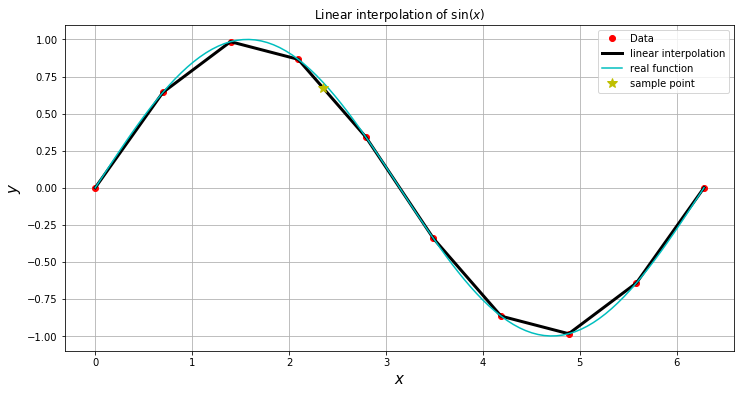

In [72]:
Ninter = 100
X=np.linspace(0, 2*np.pi, Ninter)
plt.figure( figsize=(12,6) )
plt.plot(x,f(x),'ro',label='Data')
plt.plot(X,f(X),'k-',lw=3,label='linear interpolation')
plt.plot(X,np.sin(X),'c-',label='real function')

#Formatting
plt.plot(2.35,f(2.35),'y*',markersize=10,label='sample point')
plt.title( "Linear interpolation of $\sin(x)$" )
plt.legend()
plt.xlabel( "$x$",size=15 )
plt.ylabel( "$y$",size=15 )
plt.grid()

Other `kind` values: 0,1,2

In [73]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


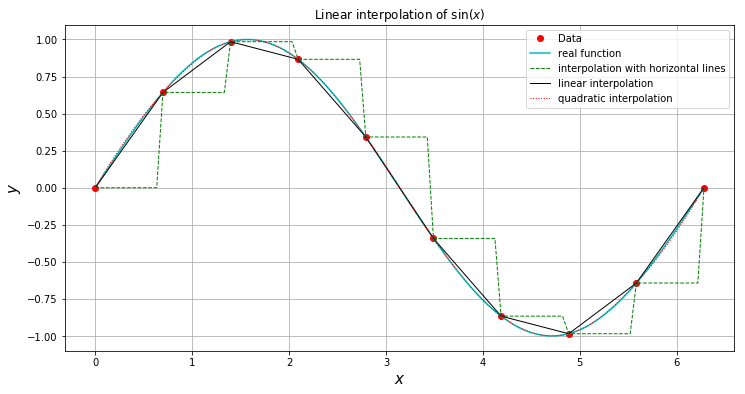

In [74]:
n_points = 10
x=np.linspace(0, 2*np.pi, n_points)
Ninter = 100
X=np.linspace(0, 2*np.pi, Ninter)
plt.figure( figsize=(12,6) )
plt.plot(x,np.sin(x),'ro',label='Data')
plt.plot(X,np.sin(X),'c-',label='real function')

plt.plot(X,interpolate.interp1d( x,np.sin(x),kind=0)(X),
         'g--',lw=1,label='interpolation with horizontal lines')
plt.plot(X,interpolate.interp1d( x,np.sin(x),kind=1)(X),
         'k-',lw=1,label='linear interpolation')
plt.plot(X,interpolate.interp1d( x,np.sin(x),kind=2)(X),
         'r:',lw=1,label='quadratic interpolation')
#plt.plot(X,interpolate.interp1d( x,np.sin(x),kind=3)(X),
#         'k:',lw=1,label='quadratic interpolation')

#Formatting
plt.title( "Linear interpolation of $\sin(x)$" )
plt.legend()
plt.xlabel( "$x$",size=15 )
plt.ylabel( "$y$",size=15 )
plt.grid()

We can see that the data poinst are just joined by straight lines:

In [ ]:
f(2.35),np.sin(2.35)

(array(0.67198441), 0.7114733527908443)

However, the object `f` behaves like a function. For example. We can evaluate both the real and the interpolated function in $x_0=3$

In [ ]:
np.sin(3)

0.1411200080598672

In [ ]:
f(3)

array(0.13335233)

**Activity**   
    
Use the previous code and explore the behaviour of the Linear Interpolation algorithm when varying the number of data used.

<!--
N=20
x=np.linspace(0,6,N)
f=interpolate.interp1d( x,np.sin(x) )
X=np.linspace(0,6,100)
plt.plot(x,f(x),'ro')
plt.plot(x,f(x),'k-',lw=3)
plt.plot(X,np.sin(X),'c-')
plt.plot(2.35,f(2.35),'y*',markersize=10)
-->

- - -

## Example: 
Generate three points that do not lie upon a stright line, and try to make a manual interpolation with a polynomial of degree two.

In [75]:
import pandas as pd
df=pd.DataFrame({ 'X':[-2.4,3,21.3],
                  'Y':[-10.,8.,3.]
                 }  
                )

In [76]:
df

,X,Y
0,-2.4,-10.0
1,3.0,8.0
2,21.3,3.0


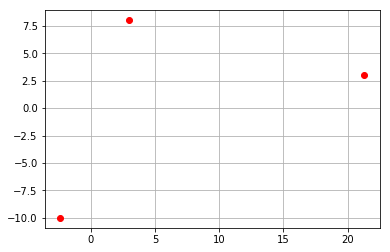

In [41]:
plt.plot(df.X,df.Y,'ro')
plt.grid()

In [42]:
sp.interpolate.interp1d?

Object `sp.interpolate.interp1d` not found.


### Polynomial object in `numpy`
In `numpy` it is possible to define polynomials friom either its coefficients o its roots with `np.poly1d`

Define a two degree polynomial from its roots:

In [77]:
import numpy as np

We try to make a fit by using an inverted parabola passing trough the tree points and using the roots as a guess.
In fact, we can try with a polynomial of degree two with roots at 1 and 22.

With $k$ we can flip the curve and reduce the maximum without change the roots

In [78]:
k=-0.1
P=k*np.poly1d([0,23],r=True)

In [79]:
print(P)

      2
-0.1 x + 2.3 x - 0


In [80]:
P.roots

array([23.,  0.])

(-15, 20)

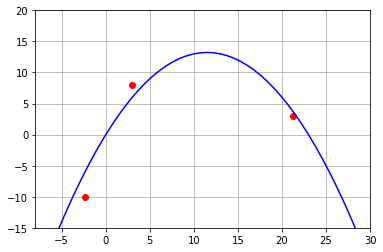

In [81]:
plt.plot(df.X,df.Y,'ro')
x=np.linspace(-8,30)
plt.plot(x,P( x),'b-')
plt.grid()
plt.xlim(-8,30)
plt.ylim(-15,20)

__Activity__: Scipy interpolation.

Define an interplation function which passes throgh the three points by using `interp1D` of Scipy with several linear and quadratic curves between the points.

<!-- 
plt.plot(df.X,df.Y,'ro')
x=sp.linspace(df.X.min(),df.X.max() )
plt.plot(x, sp.interpolate.interp1d(df.X,df.Y,kind=1)(x),label='linear')
plt.plot(x, sp.interpolate.interp1d(df.X,df.Y,kind=2)(x),label='qudratic')
plt.legend()
plt.grid()
plt.xlabel( "$x$",size=15 )
plt.ylabel( "$y$",size=15 )
plt.xlim(-8,30)
plt.ylim(-15,20)
-->

### Interpolation with `numpy`
`numpy` already include an interpolation function with polynomials called `np.polyfit`

```python
np.polyfit(x, y, deg, rcond=None, full=False, w=None, cov=False)
```

Least squares polynomial fit.

Fit a polynomial ``p(x) = p[0] * x**deg + ... + p[deg]`` of degree `deg`
to points `(x, y)`. Returns a vector of coefficients `p` that minimises
the squared error.

To fit a set of `x` and `y` we need to specify the degree of the polynial to make the fit with the madatory argument: `deg`

__Example__: fit the points of the previous DataFrame with a polynomial of degree 3

In [82]:
coeffs=np.polyfit(df.X,df.Y,deg=2)

In [83]:
np.poly1d(coeffs).roots

array([22.2373041 ,  0.26724135])

In [84]:
print(np.poly1d(coeffs))

         2
-0.1522 x + 3.425 x - 0.9043


(-20, 20)

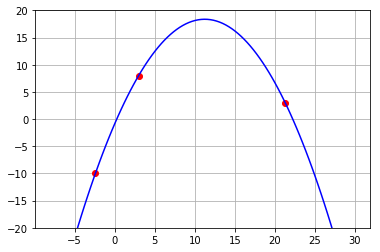

In [85]:
P=np.poly1d(coeffs)
plt.plot(df.X,df.Y,'ro')
x=np.linspace(-8,30,100)
plt.plot(x,P( x),'b-')
plt.grid()
plt.ylim(-20,20)

## Example: Least action
see Least action Notebook: [[local]](./least_action.ipynb) [[GitHub]](https://github.com/restrepo/ComputationalMethods/blob/master/material/least_action.ipynb) 

In [52]:
#np.poly1d?

# Lagrange Polynomial

Algebraic polynomials are very special functions as they have properties like differentiability (unlike linear interpolation) and continuity that make them useful for approximations like interpolation. A Polynomial is defined as a function given by the general expression:

$$P_n(x) = a_nx^n + a_{n-1}x^{n-1} + \cdots + a_1 x + a_0$$

where $n$ is the polynomial degree.

Another important property of polynomials is given by the [Weierstrass Approximation Theorem](http://en.wikipedia.org/wiki/Stone%E2%80%93Weierstrass_theorem), which states given a cotinuous function $f$ defined on a interval $[a,b]$, for all $\epsilon >0$, there exits a polynomial $P(x)$ such that

$$|f(x) - P(x)|<\epsilon\ \ \ \ \  \mbox{for all }\ x\ \mbox{ in }\ [a,b].$$

This theorem guarantees the existence of such a polynomial, however it is necessary to propose a scheme to build it.

In [86]:
import pandas as pd
df=pd.DataFrame({ 'X':[3,21.3],
                  'Y':[8.,3.]
                 }  
                )
df

,X,Y
0,3.0,8.0
1,21.3,3.0


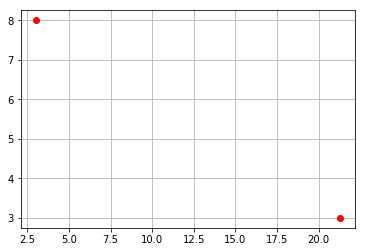

In [87]:
plt.plot(df.X,df.Y,'ro')
plt.grid()

Polinomio de interp. de grado <font color="blue">0</font>

 
5.5


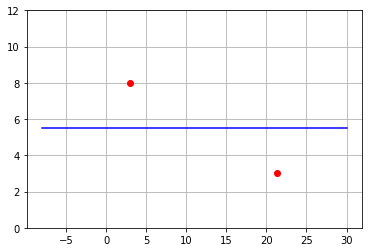

In [88]:
coeffs=np.polyfit(df.X,df.Y,deg=0)

P=np.poly1d(coeffs)
plt.plot(df.X,df.Y,'ro')
x=np.linspace(-8,30)
plt.plot(x,P( x),'b-')
plt.grid()
plt.ylim(0,12)

print(np.poly1d(coeffs))

Polinomio de interp. de grado <font color="blue">1</font>

 
-0.2732 x + 8.82


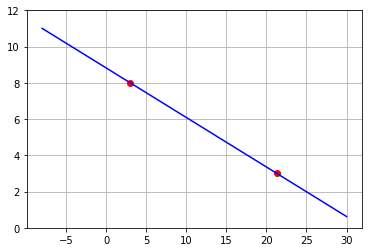

In [89]:
coeffs=np.polyfit(df.X,df.Y,deg=1)

P=np.poly1d(coeffs)
plt.plot(df.X,df.Y,'ro')
x=np.linspace(-8,30)
plt.plot(x,P( x),'b-')
plt.grid()
plt.ylim(0,12)

print(np.poly1d(coeffs))

Polinomio de interp. de grado <font color="blue">2</font>

           2
-0.008617 x - 0.06383 x + 8.269


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


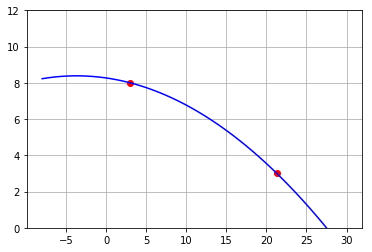

In [90]:
coeffs=np.polyfit(df.X,df.Y,deg=2)

P=np.poly1d(coeffs)
plt.plot(df.X,df.Y,'ro')
x=np.linspace(-8,30)
plt.plot(x,P( x),'b-')
plt.grid()
plt.ylim(0,12)

print(np.poly1d(coeffs))

In [91]:
df=df.append({'X':10,'Y':6.5},ignore_index=True).sort_values('X')
df.to_csv('../data/interpolation.csv',index=False)
df

,X,Y
0,3.0,8.0
2,10.0,6.5
1,21.3,3.0


           2
-0.005216 x - 0.1465 x + 8.486


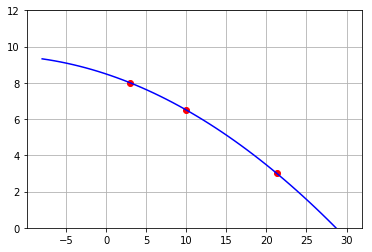

In [92]:
coeffs=np.polyfit(df.X,df.Y,deg=2)

P=np.poly1d(coeffs)
plt.plot(df.X,df.Y,'ro')
x=np.linspace(-8,30)
plt.plot(x,P( x),'b-')
plt.grid()
plt.ylim(0,12)

print(np.poly1d(coeffs))

In [93]:
print(np.poly1d(coeffs))

           2
-0.005216 x - 0.1465 x + 8.486


## Derivation

Let's suppose a well-behaved yet unknown function $f$ and two points $(x_0,y_0)$ and $(x_1,y_1)$ for which $f(x_0) = y_0$ and $f(x_1) = y_1$. With this information we can build a first-degree polynomial that passes through both points by using the last equation in sec. [Linear Interpolation](interpolation.ipynb#Linear-Interpolation), we have

$$P_1(x) = \left[ \frac{y_{1}-y_0}{x_{1}-x_0} \right]x + \left[ y_0 - \frac{y_{1}-y_0}{x_{1}-x_0}x_0 \right]$$

We can readily rewrite this expression like:
\begin{align}
P_1(x) =& \frac{y_{1}}{x_{1}-x_0} x- \frac{y_0}{x_{1}-x_0} x + y_0 -\frac{y_{1}}{x_{1}-x_0}x_0 +  \frac{y_0}{x_{1}-x_0}x_0 \nonumber\\
=& \left[1 - \frac{x}{x_{1}-x_0}  +  \frac{x_0}{x_{1}-x_0}\right]y_0+
\left[\frac{x}{x_{1}-x_0}  -\frac{x_0}{x_{1}-x_0}\right]y_1    \nonumber\\
 =& \left[\frac{x_1-x_0}{x_{1}-x_0} - \frac{x}{x_{1}-x_0}  +  \frac{x_0}{x_{1}-x_0}\right]y_0+
\left[\frac{x}{x_{1}-x_0}  -\frac{x_0}{x_{1}-x_0}\right]y_1    \nonumber\\
=& \left[\frac{x_1-x}{x_{1}-x_0}\right]y_0+
\left[\frac{x-x_0}{x_{1}-x_0}\right]y_1    \,.
\end{align}
In this way
$$P_1(x) = L_0(x)f(x_0) + L_1(x)f(x_1)$$

where we define the functions $L_0(x)$ and $L_1(x)$ as:

$$L_0(x) = \frac{x-x_1}{x_0-x_1} \mbox{ and } L_1(x) = \frac{x-x_0}{x_1-x_0}$$

Note that

$$L_0(x_0) = 1,\ \ \ L_0(x_1) = 0,\ \ \ L_1(x_0) = 0,\ \ \ L_1(x_1) = 1$$

implying:

$$P_1(x_0) = f(x_0) = y_0$$

$$P_1(x_1) = f(x_1) = y_1$$

Although all this procedure may seem unnecessary for a polynomial of degree 1, a generalization to polynomials of larger degrees is now possible.

## General case
Let's assume again a well-behaved and unknown function $f$ sampled by using a set of $n+1$ data $(x_m,y_m)$ ($0\leq m \leq n$).
We call the set of $[x_0,x_1,\ldots,x_n]$ as the _node_ points of the _interpolation polynomial in the Lagrange form_, $P_n(x)$, where:
$$f(x)\approx P_n(x)\,,$$

$$P_n(x) = \sum_{i=0}^n f(x_i)L_{n,i}(x) = \sum_{i=0}^n y_iL_{n,i}(x)$$

Such that
$$f(x_i)= P_n(x_i)\,,$$

We need to find the _Lagrange polynomials_,  $L_{n,i}(x)$, such that 
$$L_{n,i}(x_i) = 1\,,\qquad\text{and}\,,\qquad L_{n,i}(x_j) = 0\quad\text{for $i\neq j$}$$ 
A function that satisfies this criterion is

$$L_{n,i}(x) = \prod_{\begin{smallmatrix}m=0\\ m\neq i\end{smallmatrix}}^n \frac{x-x_m}{x_i-x_m} =\frac{(x-x_0)}{(x_i-x_0)}\frac{(x-x_1)}{(x_i-x_1)}\cdots \frac{(x-x_{i-1})}{(x_i-x_{i-1})}\underbrace{\frac{}{}}_{m\ne i}
\frac{(x-x_{i+1})}{(x_i-x_{i+1})} \cdots \frac{(x-x_{n-1})}{(x_i-x_{n-1})}\frac{(x-x_n)}{(x_i-x_n)}  $$
Please note that in the expansion the term $(x-x_i)$ does not appears in both the numerator and the denominator as stablished in the productory condition $m\neq i$.

Moreower
$$L_{n,i}(x_i) = \prod_{\begin{smallmatrix}m=0\\ m\neq i\end{smallmatrix}}^n \frac{x_i-x_m}{x_i-x_m} =1$$
and, for $j\ne i$
$$L_{n,i}(x_j) = \prod_{\begin{smallmatrix}m=0\\ m\neq i\end{smallmatrix}}^n \frac{x_j-x_m}{x_i-x_m} =\frac{(x_j-x_0)}{(x_i-x_0)}\cdots \frac{(\boldsymbol{x_j}-\boldsymbol{x_j})}{(x_i-x_j)}\cdots\frac{(x_j-x_n)}{(x_i-x_n)}=0.$$


Then, the polynomial of $n$th-degree $P_n(x)$ will satisfy the definitory property for a interpolating polynomial, i.e. $P_n(x_i) = y_i$ for any $i$ and it is called the _interpolation Polynomial in the Lagrange form_.

Check [this implementation in sympy](./LagrangePoly.ipynb) [[View in Colaboratory](https://colab.research.google.com/github/restrepo/ComputationalMethods/blob/master/material/LagrangePoly.ipynb)] where both the interpolating polynomial and the Lagrange polynomials are defined.

**Further details at:**
[Wikipedia](https://en.wikipedia.org/wiki/Lagrange_polynomial)

### Example:
Obtain the Lagrange Polynomials for a Interpolation polynomial of degree 1.

$i=0$, $n=1$
$$ L_{1,0}=\prod_{\begin{smallmatrix}m=0\\ m\neq 0\end{smallmatrix}}^1 \frac{x-x_m}{x_i-x_m}=\prod_{\begin{smallmatrix}m=1\end{smallmatrix}}^1 \frac{x-x_m}{x_0-x_m}=\frac{x-x_1}{x_0-x_1}$$
$i=i$, $n=1$
$$ L_{1,1}=\prod_{\begin{smallmatrix}m=0\\ m\neq 1\end{smallmatrix}}^1 \frac{x-x_m}{x_i-x_m}=\prod_{\begin{smallmatrix}m=0\end{smallmatrix}}^0 \frac{x-x_m}{x_1-x_m}=\frac{x-x_0}{x_1-x_0}$$

Until now we can only guarantee that $P_n(x_i)=f(x_i)$. To calculate the function from any $x$ in the interpolation interval we have the following Theorem (See [here](https://www3.nd.edu/~zxu2/acms40390F12/Lec-3.1.pdf))
## Theorem
Suppose $X_0,\ldots,x_n$ are distinct numbers in the interval $[a,b]$ and $f\in[a,b]$.Then for each $x$ in $[a,b]$, a number $\xi(x)$ between $x_0,\ldots,x_n$, and hence in $[a,b]$, exists with
$$
f(x)=P_n(x)+E_n(x)\,,\qquad \text{such that } E_n(x_i)=0\,,
$$
where the formula for the error bound is given by
$$
E_n(x) = {f^{n+1}(\xi(x)) \over (n+1)!} \cdot \prod_{i=0}^{n}\left(x-x_{i}\right)\,,
$$
$f^{(n+1)}$ is the $n+1$ derivative of $f$

For a demostration see [1d] → https://www.math.ust.hk/~mamu/courses/231/Slides/CH03_1B.pdf

The specific calculation of the bounded error is to find the $\xi$ and $x$ such that
$$
\left|f(x)-P(x)\right| \leq \max_{\xi\in[a,b]}\left|\frac{f^{(n+1)}(\xi)}{(n+1) !}\right| \cdot \max_{x\in[a,b]}\left|\prod_{i=0}^{n}\left(x-x_{i}\right)\right|
$$

### Exercise-interpolation
Obtain the Lagrange Polynomials for a Interpolation polynomial of degree 2.

### Implementation in Scipy

In [61]:
from scipy import interpolate

In [94]:
#interpolate.lagrange?

In [96]:
df

,X,Y
0,3.0,8.0
2,10.0,6.5
1,21.3,3.0


In [97]:
P=interpolate.lagrange(df.X,df.Y)
print(P)

           2
-0.005216 x - 0.1465 x + 8.486


(0, 12)

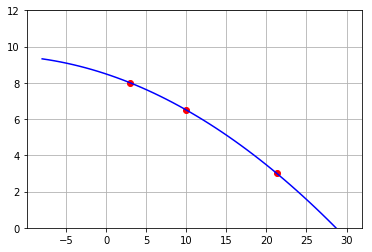

In [98]:
plt.plot(df.X,df.Y,'ro')
x=np.linspace(-8,30)
plt.plot(x,P( x),'b-')
plt.grid()
plt.ylim(0,12)

### Example of error calculation
See details [here](https://math.stackexchange.com/a/1151599/790274)

Consider $f(x) = \operatorname{e}^{2x} - x$ interpolation in the interval $(1,1.6)$ 

1. Construct the Lagrange Polynomial for the points $x_0=1$, $x_1=1.25$, $x_2=1.6$. 
1. Find the approximate value at $f(1.5)$ and the error bound for the approximation

1. We start by defining the function

Be sure that the function input will be an array

In [68]:
#Wrong result for a list
x=[1,1.25,1.6]
np.exp(2*x)

array([2.71828183, 3.49034296, 4.95303242, 2.71828183, 3.49034296,
       4.95303242])

In [69]:
np.exp(2*np.array(x))

array([ 7.3890561 , 12.18249396, 24.5325302 ])

In [70]:
#List operations are not well defined in general
[1,2,4]-[1,5,6]

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [72]:
def f(x):
    '''
    WARNING: all the parts of the function must be 
    numpy arrays in order to get the element by element sum.
    '''
    x=np.asarray(x) # Force x → array
    return np.exp(2*x)-x

The interpolation polynomial is

In [34]:
x=[1,1.25,1.6]
P_2=interpolate.lagrange(x,f(x))
print(P_2)

       2
26.85 x - 42.25 x + 21.78


Test interpolation with one of the three points

In [35]:
P_2(x[1]),f(x[1])

(10.932493960703491, 10.932493960703473)

For the bounded error we start with the left part
$$
\max_{\xi\in[1,1.6]}\left|\frac{f'''(\xi)}{(3)!}\right| 
$$
where
$$f'(x)=2\operatorname{e}^{2x}-1$$
$$f''(x)=4\operatorname{e}^{2x}$$
$$f'''(x)=8\operatorname{e}^{2x}$$
The maximum is obtained for the last point $x_2$

In [36]:
fppp=8*np.exp(2*x[2])
fppp

196.26024157687482

For the right part 
$$
\max_{x\in[a,b]}\left|\prod_{i=0}^{2}\left(x-x_{i}\right)\right|=
$$
we need just to build the numpy polynomial with roots at $(x_0,x_1,x_2)$
$$
p(x)=(x-x_0)(x-x_1)(x-x_2)\,,
$$

In [37]:
p=np.poly1d(x,r=True)

And find the maximun of the absolute value of the critical points

In [48]:
p.deriv().roots

array([1.45733844, 1.10932822])

In [49]:
p(p.deriv().roots)

array([-0.01352772,  0.00754624])

In [38]:
pmax=np.abs( p(p.deriv().roots) ).max()

In this way, the maximum error for $p(x)$ is expected for $x_{\text{max}}=1.45733844$

The bounded error is then
$$
E_2(x)=\max_{\xi\in[1,1.6]}\left|\frac{f'''(\xi)}{(3)!}\right|\cdot\max_{x\in[a,b]}\left|\prod_{i=0}^{2}\left(x-x_{i}\right)\right|
$$

In [39]:
pmax

0.013527716754363928

In [40]:
E_2=fppp/(2*3)*pmax
E_2

0.4424921596991669

In [56]:
X=1.5
f(X)

18.585536923187668

In [57]:
P_2(X)

18.832612316478652

In [58]:
P_2(X)-f(X)

0.24707539329098438

The real bounded error is

In [61]:
xlin=np.linspace(x[0],x[-1],100)
np.abs(P_2(xlin)-f(xlin)).max()

0.26182823963596036

### Implementation in `sympy`
For details see [here](./LagrangePoly.ipynb)

In [66]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [67]:
df=pd.read_csv('https://github.com/restrepo/ComputationalMethods/raw/master/data/interpolation.csv')

In [99]:
import LagrangePolynomial as LP
LP.lagrangePolynomial(df.X,df.Y)

-0.00521578136549848*x**2 - 0.146480556534234*x + 8.48638370189219

$$P_n(x) =  \sum_{i=0}^n L_{n,i}(x) \, y_i$$

In [100]:
LP.polyL( df.X,0)*df.Y[0]+LP.polyL( df.X,1)*df.Y[1]+LP.polyL( df.X,2)*df.Y[2]

0.0559573894841558*x**2 - 1.44173177757974*x + 11.8215788273818

In [102]:
df

,X,Y
0,3.0,8.0
2,10.0,6.5
1,21.3,3.0


In [103]:
df.X[0]

3.0

## Steps LP

Once defined the formal procedure for constructing a Lagrange Polynomial, we proceed to describe the explicit algorithm:

1. Give the working dataset $(x_i, y_i)$ and stablish how many points you have.
2. Define the functions $L_{n,i}(x)$ in a general way.
3. Add each of those terms as shown in last expression.
4. Evaluate your result wherever you want.

**Activity**

Along with the professor, write an implementation of the previous algorithm during classtime.

## Activity LP

<div style="float: right;" markdown="1">
    <img src="http://universe-review.ca/I05-28-NGC7331.jpg">
</div>

One of the very first evidences of the existence of dark matter was the flat rotation curves of spiral galaxies. If we assume the total budget of mass of a galaxy is entirely made of luminous matter, the orbital circular velocity of stars around the galaxy plane should decay according to a keplerian potential. However this is not the case and the circular velocity barely decreases at larger radius, thus indicating the presence of a new non-visible matter component (dark matter). When it is necessary to determine how massive is the dark matter halo embedding a galaxy, an integration of the circular velocity is required. Nevertheless, due to the finite array of a CCD camera, only a discrete set of velocities can be measured and interpolation techniques are required.


In this activity we will take a discrete dataset of the circular velocity as a function of the radius for the galaxy [NGC 7331](http://es.wikipedia.org/wiki/NGC_7331) and perform both, a linear and a Lagrange interpolation. You can download the dataset from this [link](https://raw.githubusercontent.com/sbustamante/ComputationalMethods/master/data/NGC7331.dat).


[Video](https://upload.wikimedia.org/wikipedia/commons/transcoded/3/33/Galaxy_rotation_under_the_influence_of_dark_matter.ogv/Galaxy_rotation_under_the_influence_of_dark_matter.ogv.360p.webm)

<font color='blue'>
**TRIVIA**<br/> 
To which of two curves the real data approach better?
</font>

import os
os.remove('trivia_results.txt')

In [11]:
f=open('trivia_results.txt','a')
AB=input(r'''A: to the curve "velocity goes to zero when distance goes to infinity"
B: to the curve "velocity goes to high constant when distance goes to infinity"
''')
f.write( '{}\n'.format(AB) )
f.close()

A: to the curve "velocity goes to zero when distance goes to infinity"
B: to the curve "velocity goes to high constant when distance goes to infinity"
 A


In [12]:
fr=open('trivia_results.txt')
print( fr.read())
fr.close()

C
A



os.remove('trivia_results.txt')

### Lets us check! 

In [28]:
#DATA URL: 
url='https://raw.githubusercontent.com/restrepo/ComputationalMethods/master/data/NGC7331.csv'
df=pd.read_csv(url)
df[0:5]

,r,v
0,0.05,33.42496
1,0.10,71.70398
2,0.15,95.14708
3,0.20,107.32276
4,0.25,117.44285


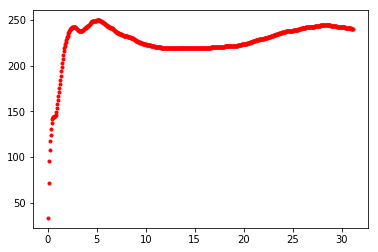

In [31]:
plt.plot(df.r,df.v,'r.')

Build expected data

In [32]:
dff=df[:60]
#dff=dff.append(pd.DataFrame( {'r':[5,10],'v':[60,20]} )).reset_index(drop=True) # ,15,20,25,30 ,120,105,100,98
#dff=dff.append(pd.DataFrame( {'r':[3.5,4,10],'v':[230,200,20]} )).reset_index(drop=True) # ,15,20,25,30 ,120,105,100,98
dff=dff.append(pd.DataFrame( {'r':[3.5,4,9],'v':[230,200,22]} )).reset_index(drop=True) # ,15,20,25,30 ,120,105,100,98

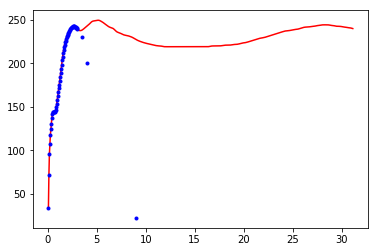

In [33]:
plt.plot(df['r'],df['v'],'r-')
plt.plot(dff.r, dff.v,'b.')

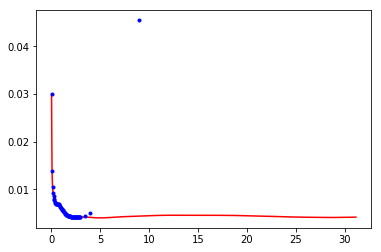

In [ ]:
plt.plot(df['r'],1./df['v'],'r-')
plt.plot(dff['r'],1./dff['v'],'b.')

In [ ]:
coeff=np.polyfit(dff['r'],1./dff['v'],2)
P=poly1d(coeff,variable='r')
print(P)

          2
0.001084 r - 0.00594 r + 0.01169


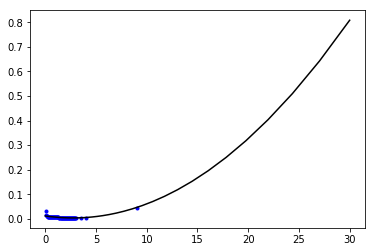

In [ ]:
r=np.logspace( np.log10(0.001),np.log10(30 ),100 )
plt.plot(dff['r'],1./dff['v'],'b.')
plt.plot(r,P(r),'k-')

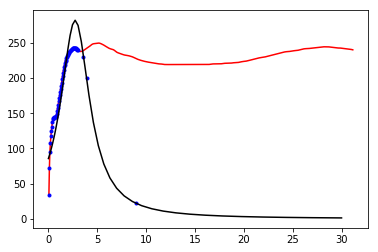

In [ ]:
plt.plot(df['r'],df['v'],'r-')
plt.plot(dff['r'],dff['v'],'b.')
plt.plot(r,1/P(r),'k-')

- - -

In [ ]:
np.log(2)/0.105

6.601401719618527

###  Logarithmic interpolation
See: https://stackoverflow.com/a/29359275/2268280

# Appendix
Thecnical details of interpolation functions: [interpolation_details.ipynb](./interpolation_details.ipynb)

<span style="color:blue">some *blue* text</span>.

Hola